In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import re
from ekphrasis.classes.segmenter import Segmenter
import preprocessor as p
from wordcloud import WordCloud
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [2]:
from matplotlib import colors
import time

#Datasets generation
from sklearn.datasets import make_circles, make_blobs, make_classification, make_moons, make_gaussian_quantiles

#Classification models
from sklearn.linear_model import LogisticRegression as LR
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier as RFc
from sklearn.tree import DecisionTreeClassifier as DTc
from sklearn.svm import SVC as SVMc
from sklearn.neural_network import MLPClassifier as MLPc
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.naive_bayes import GaussianNB as GNB

from sklearn.model_selection import train_test_split

#GridSearch
from sklearn.model_selection import GridSearchCV

#Model metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package wordnet to /home/miguel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/miguel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/miguel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
data = pd.read_csv('FN-Dataset-18k.csv')
data = data.round(2)
data.head()

,id,questionable_domain,user_friends_count,user_followers_count,user_favourites_count,user_verified,description,title,favorite_count,retweet_count,contains_profanity
0,1.310325e+18,False,3822,1084,49451,False,"Glad to hear that the @SenateDems, @HouseDemoc...","Glad to hear that the @SenateDems, @HouseDemoc...",0,0,False
1,1.310896e+18,True,4378,30443,113064,False,If only those people who swim against the curr...,If only those people who swim against the curr...,56,26,False
2,1.311657e+18,False,29,43,0,False,@nytimes https://t.co/5FFoZ2GZFx If chaos or ...,@nytimes https://t.co/5FFoZ2GZFx If chaos or ...,0,0,False
3,1.312330e+18,False,400,4857,1942,False,@yemyat91 @Int_IDEA At least two Rohingya cand...,@yemyat91 @Int_IDEA At least two Rohingya cand...,2,0,False
4,1.313137e+18,False,98,825,2848,False,The Secret History of Kimberly Guilfoyle’s Dep...,The Secret History of Kimberly Guilfoyle’s Dep...,0,0,False


In [5]:
data.describe()

,id,user_friends_count,user_followers_count,user_favourites_count,favorite_count,retweet_count
count,1.795000e+04,17950.000000,1.795000e+04,17950.000000,17950.000000,17950.000000
mean,1.325966e+18,3572.242563,2.173663e+04,31120.704123,16.252423,5.508078
std,8.116901e+15,12278.236622,5.315508e+05,64673.930489,248.299352,118.042495
min,1.309593e+18,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.319219e+18,243.000000,1.050000e+02,1463.000000,0.000000,0.000000
50%,1.326489e+18,910.000000,6.810000e+02,8555.000000,0.000000,0.000000
75%,1.332321e+18,3012.000000,3.462750e+03,31629.000000,1.000000,0.000000
max,1.342944e+18,494338.000000,4.814076e+07,909295.000000,13180.000000,12858.000000


In [6]:
#data[(data['favorite_count'] > 1000) | (data['retweet_count'] > 500) | (data['user_friends_count'] > 50000) | (data['user_followers_count'] > 200000) | (data['user_favourites_count'] > 200000)].describe()

In [7]:
#data = data[(data['favorite_count'] <= 1000) & (data['retweet_count'] <= 500) & (data['user_friends_count'] <= 50000) & (data['user_followers_count'] <= 200000) & (data['user_favourites_count'] <= 200000)]

In [8]:
data.describe()

,id,user_friends_count,user_followers_count,user_favourites_count,favorite_count,retweet_count
count,1.795000e+04,17950.000000,1.795000e+04,17950.000000,17950.000000,17950.000000
mean,1.325966e+18,3572.242563,2.173663e+04,31120.704123,16.252423,5.508078
std,8.116901e+15,12278.236622,5.315508e+05,64673.930489,248.299352,118.042495
min,1.309593e+18,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,1.319219e+18,243.000000,1.050000e+02,1463.000000,0.000000,0.000000
50%,1.326489e+18,910.000000,6.810000e+02,8555.000000,0.000000,0.000000
75%,1.332321e+18,3012.000000,3.462750e+03,31629.000000,1.000000,0.000000
max,1.342944e+18,494338.000000,4.814076e+07,909295.000000,13180.000000,12858.000000


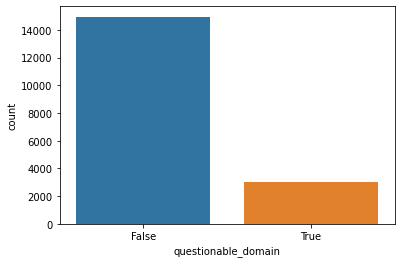

In [9]:
ax = sns.countplot(x="questionable_domain", data=data)

In [10]:
data.isnull().sum()

id                       0
questionable_domain      0
user_friends_count       0
user_followers_count     0
user_favourites_count    0
user_verified            0
description              0
title                    0
favorite_count           0
retweet_count            0
contains_profanity       0
dtype: int64

In [11]:
data_num = data[['user_friends_count', 'user_followers_count', 'user_favourites_count', 'favorite_count', 'retweet_count']]

In [12]:
data_num = data_num.round(2)

In [13]:
data_num.describe().round(2)

,user_friends_count,user_followers_count,user_favourites_count,favorite_count,retweet_count
count,17950.00,17950.00,17950.00,17950.00,17950.00
mean,3572.24,21736.63,31120.70,16.25,5.51
std,12278.24,531550.78,64673.93,248.30,118.04
min,0.00,0.00,0.00,0.00,0.00
25%,243.00,105.00,1463.00,0.00,0.00
50%,910.00,681.00,8555.00,0.00,0.00
75%,3012.00,3462.75,31629.00,1.00,0.00
max,494338.00,48140763.00,909295.00,13180.00,12858.00


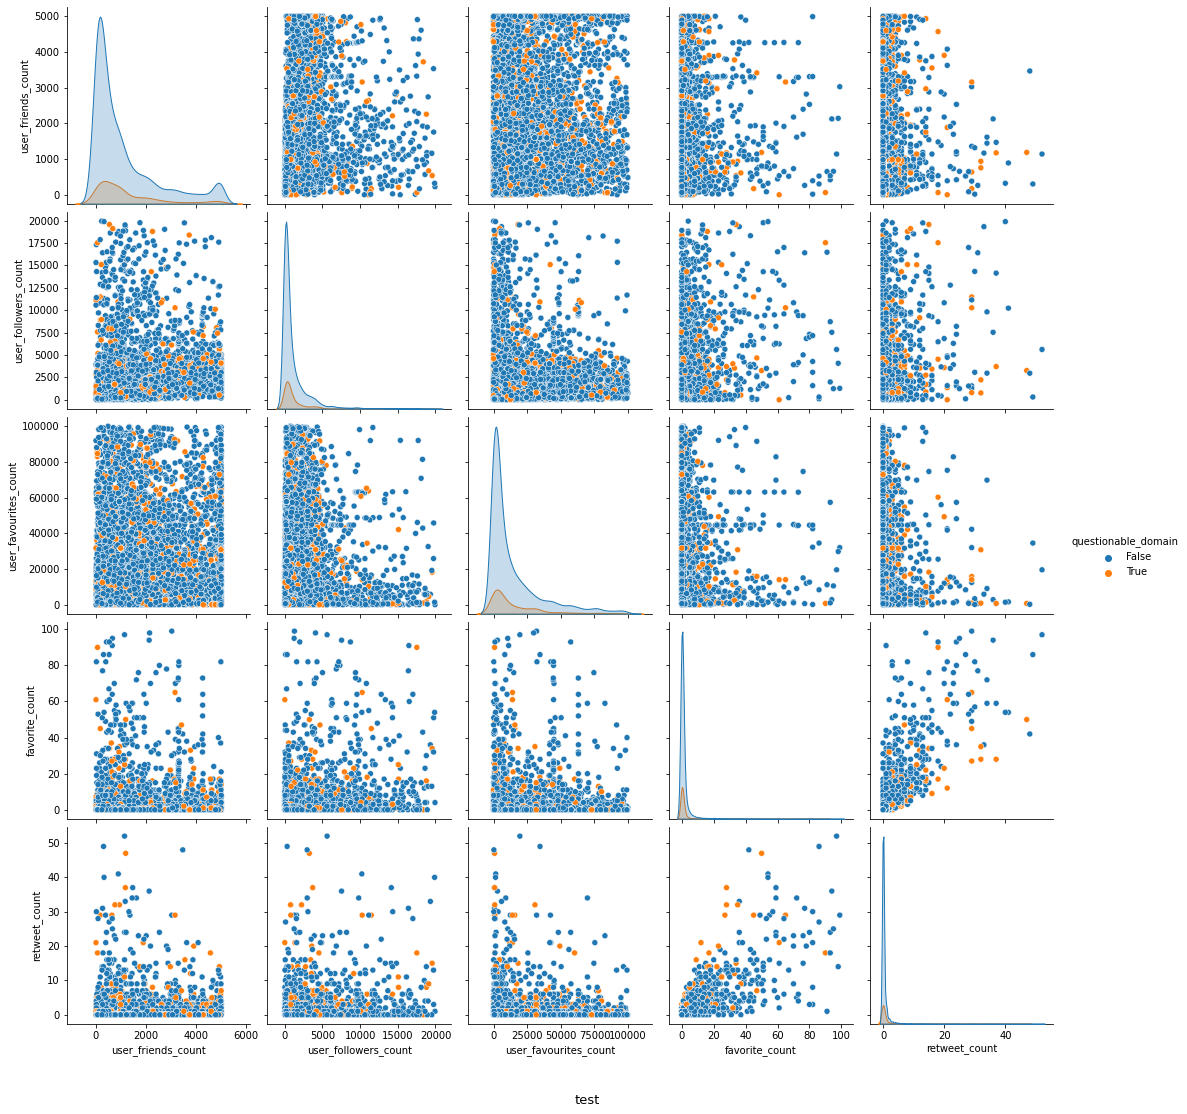

In [14]:
data_num_2 = data[['questionable_domain','user_friends_count', 'user_followers_count', 'user_favourites_count', 'favorite_count', 'retweet_count']]
data_num_2 = data_num_2[(data_num_2['favorite_count'] <= 100) & (data_num_2['retweet_count'] <= 100) & (data_num_2['user_friends_count'] <= 5000) & (data_num_2['user_followers_count'] <= 20000) & (data_num_2['user_favourites_count'] <= 100000)]
sns.pairplot(data_num_2, hue = 'questionable_domain', size=3.0)
txt="test"
plt.figtext(0.5, -0.03, txt, wrap=True, horizontalalignment='center', fontsize=13)
plt.show();

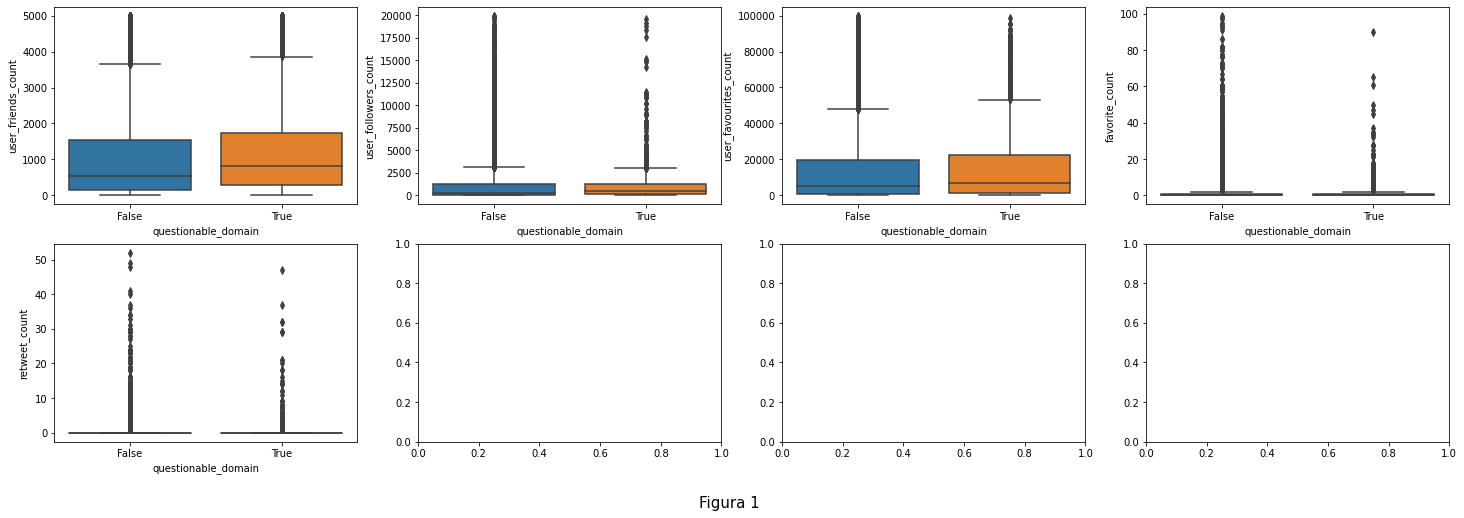

In [15]:
cols = data_num_2.columns[1:6]
fig, ax = plt.subplots(2,4, sharex=False, sharey=False, figsize=(25, 8))
txt="Figura 1"
plt.figtext(0.5, 0.01, txt, wrap=True, horizontalalignment='center', fontsize=15)
for i in range(len(cols)):
    sns.boxplot(ax=ax[i//4, i%4], y=cols[i], x='questionable_domain', data=data_num_2)
    ax[i//4, i%4].set(xlabel='questionable_domain')
plt.show();

In [16]:
data.drop(columns='favorite_count', inplace=True)

In [17]:
data.reset_index(drop=True, inplace=True)

## preprocessing tweets

In [18]:
data['hashtag'] = data['description'].apply(lambda x: re.findall(r"#(\w+)",x))
data['mention'] = data['description'].apply(lambda x: re.findall(r"@(\w+)",x))

In [19]:
data['description'] = data['description'].astype('string')
data['title'] = data['title'].astype('string')

In [20]:
data['text']=''
for i in range(data['description'].shape[0]):
    data.loc[i,'text'] = p.clean(data.iloc[i]['description'])

In [21]:
def preprocess_data(data):
    #Removes Numbers
    data = data.str.replace('\d+', '')
    lower_text = data.str.lower()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    w_tokenizer =  TweetTokenizer()
 
    def lemmatize_text(text):
        return [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((text))]
        
    def remove_punctuation(words):
        new_words = []
        for word in words:
            new_word = re.sub(r'[^\w\s]', '', (word))
            if new_word != '':
                new_words.append(new_word)
        return new_words
    
    words = lower_text.apply(lemmatize_text)
    words = words.apply(remove_punctuation)
    return pd.DataFrame(words)

In [22]:
data['text'] = preprocess_data(data['text'])

In [23]:
stop_words = set(stopwords.words('english'))

data['text'] = data['text'].apply(lambda x: [item for item in x if item not in stop_words])

In [24]:
seg_tw = Segmenter(corpus="twitter")
a = []
for i in range(len(data)):
    if data['hashtag'][i] != a:
        listToStr1 = ' '.join([str(elem) for elem in data['hashtag'][i]])
        data.loc[i,'Segmented#'] = seg_tw.segment(listToStr1)
    elif data['mention'][i] != a:
        listToStr2 = ' '.join([str(elem) for elem in data['mention'][i]])
        data.loc[i,'Segmented@'] = seg_tw.segment(listToStr2)

Reading twitter - 1grams ...
Reading twitter - 2grams ...


In [25]:
data_test_hashtag = data[['questionable_domain', 'Segmented#']]
data_test_hashtag = data_test_hashtag.replace({'Segmented#':{'nan':np.nan}}).dropna(subset=['Segmented#'])
data_test_hashtag.reset_index(drop=True, inplace=True)

In [26]:
data_test_at = data[['questionable_domain', 'Segmented@']]
data_test_at = data_test_at.replace({'Segmented@':{'nan':np.nan}}).dropna(subset=['Segmented@'])
data_test_at.reset_index(drop=True, inplace=True)

In [27]:
#data['Segmented#'] = data['Segmented#'].astype(str)

In [28]:
fdist_true_hash = FreqDist(data_test_hashtag['Segmented#'][(data_test_hashtag['questionable_domain']== True)])
fdist_false_hash = FreqDist(data_test_hashtag['Segmented#'][(data_test_hashtag['questionable_domain']== False)])
fdist_false_common_hash = FreqDist(fdist_false_hash).most_common(20)
fdist_false_common_hash = pd.Series(dict(fdist_false_common_hash))
fdist_true_common_hash = FreqDist(fdist_true_hash).most_common(20)
fdist_true_common_hash = pd.Series(dict(fdist_true_common_hash))


fdist_true_at = FreqDist(data_test_at['Segmented@'][(data_test_at['questionable_domain']== True)])
fdist_false_at = FreqDist(data_test_at['Segmented@'][(data_test_at['questionable_domain']== False)])
fdist_false_common_at = FreqDist(fdist_false_at).most_common(10)
fdist_false_common_at = pd.Series(dict(fdist_false_common_at))
fdist_true_common_at = FreqDist(fdist_true_at).most_common(10)
fdist_true_common_at = pd.Series(dict(fdist_true_common_at))

In [29]:
def show_freq(dataframe, k):
    fdist = FreqDist(dataframe.iloc[:,1])
    fdist_true = FreqDist(dataframe.iloc[:,1][(dataframe['questionable_domain']== True)])
    fdist_false = FreqDist(dataframe.iloc[:,1][(dataframe['questionable_domain']== False)])

    print('Most commont words')
    wc = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist)
    plt.figure(figsize=(20,12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    print('Most commont words in false')
    wc_false = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_false)
    plt.figure(figsize=(20,12))
    plt.imshow(wc_false, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    print('Most commont words in true')
    wc_true = WordCloud(width=800, height=400, max_words=50).generate_from_frequencies(fdist_true)
    plt.figure(figsize=(20,12))
    plt.imshow(wc_true, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    fdist_false_common = FreqDist(fdist_false).most_common(k)
    fdist_false_common = pd.Series(dict(fdist_false_common))
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_title('most common words in false')
    all_plot = sns.barplot(x=fdist_false_common.index, y=fdist_false_common.values, ax=ax)
    plt.xticks(rotation=30);

    fdist_true_common = FreqDist(fdist_true).most_common(k)
    fdist_true_common = pd.Series(dict(fdist_true_common))
    fig, ax = plt.subplots(figsize=(30,10))
    ax.set_title('most common words in true')
    all_plot = sns.barplot(x=fdist_true_common.index, y=fdist_true_common.values, ax=ax)
    plt.xticks(rotation=30);





Most commont words


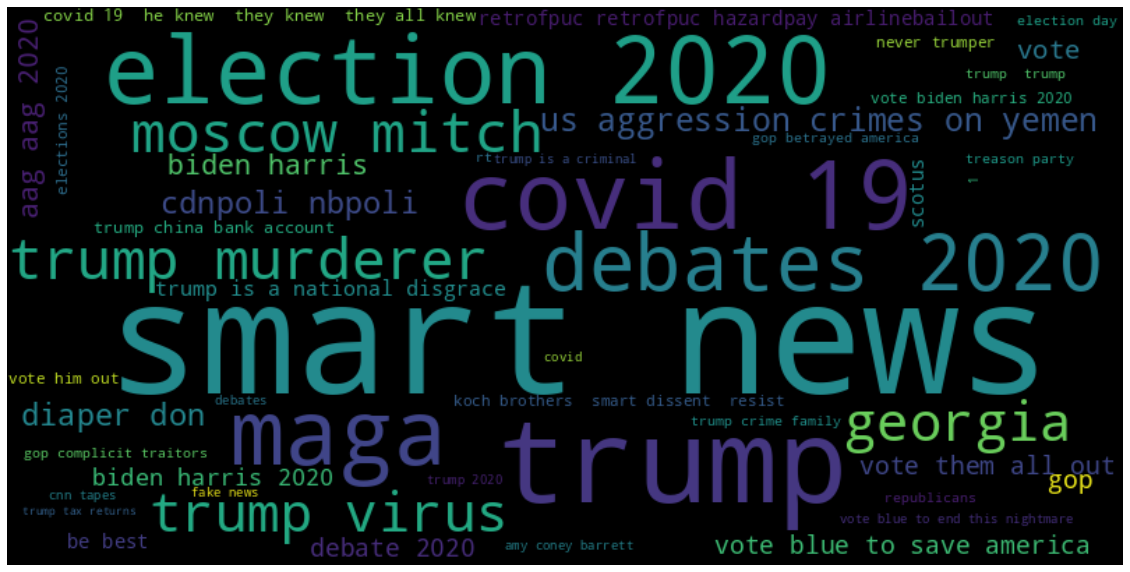

Most commont words in false


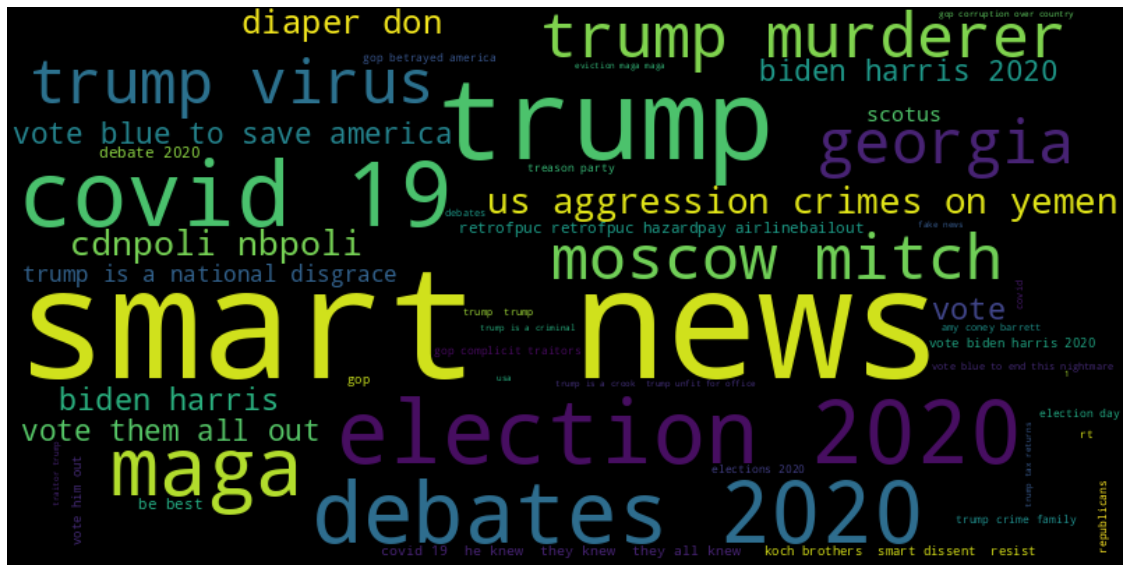

Most commont words in true


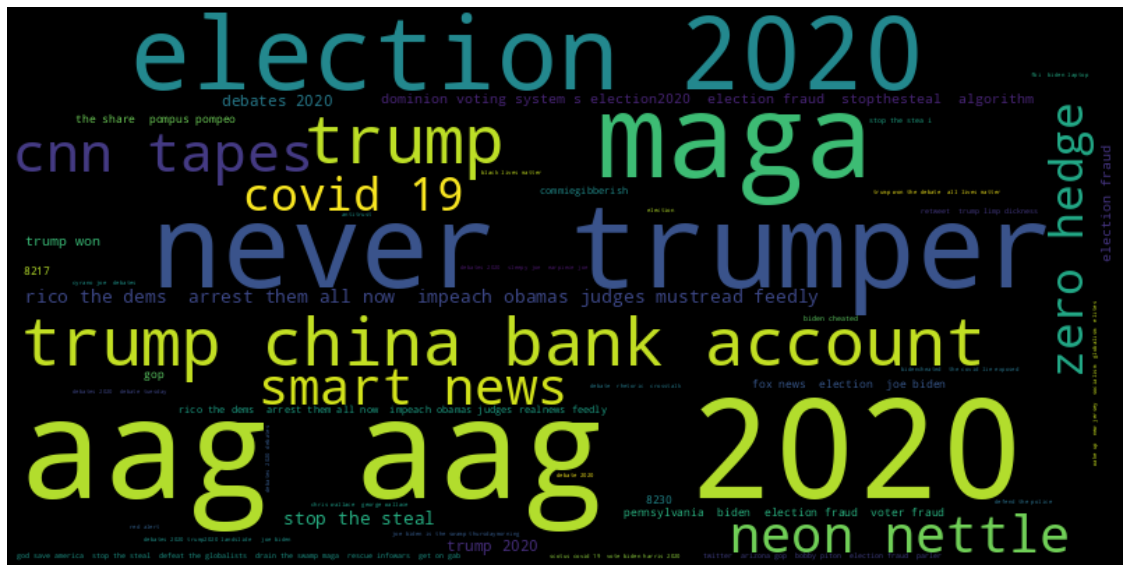

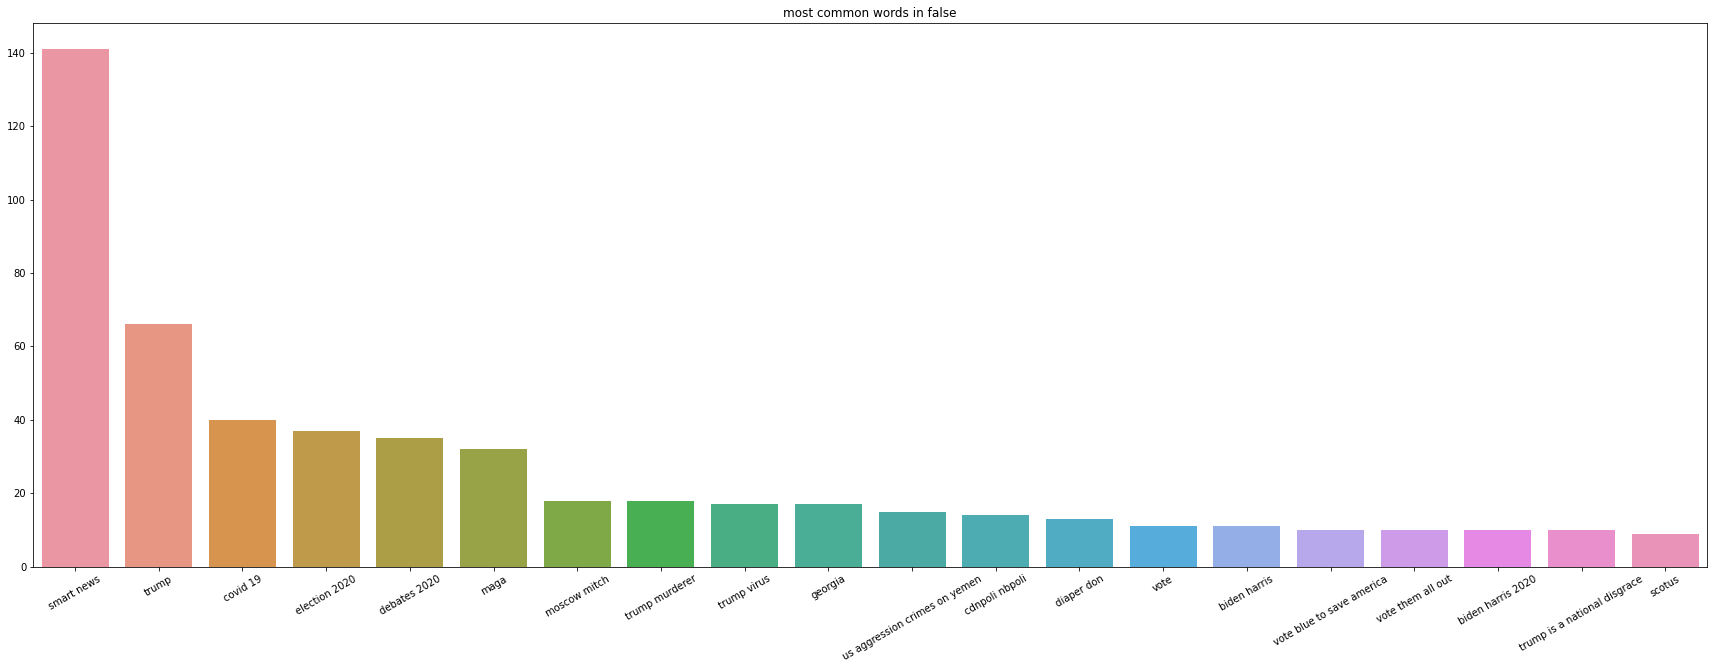

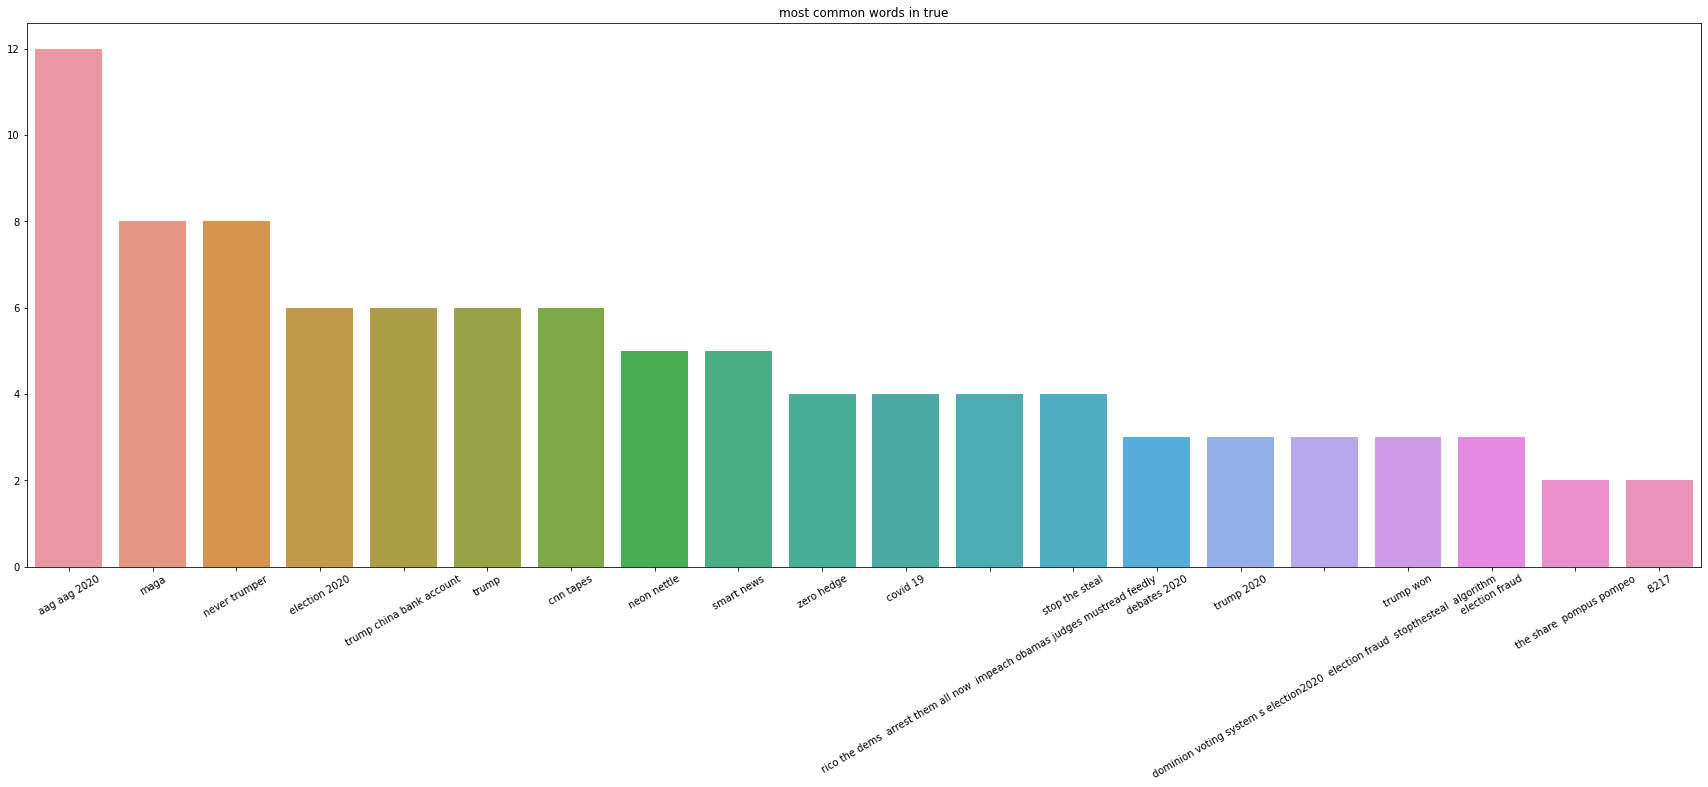

In [30]:
show_freq(data_test_hashtag, 20)

Most commont words


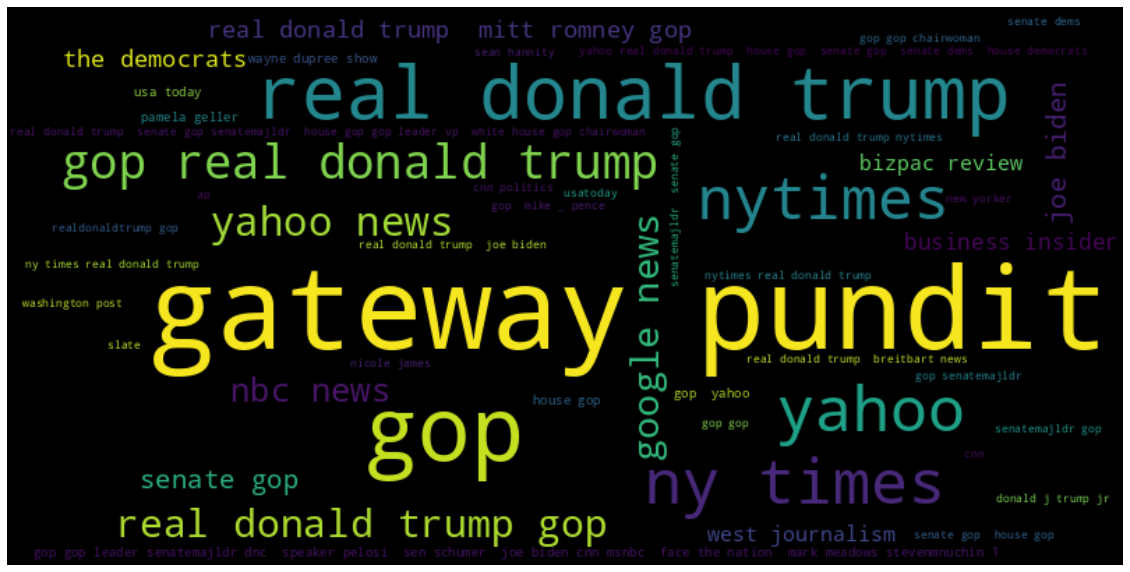

Most commont words in false


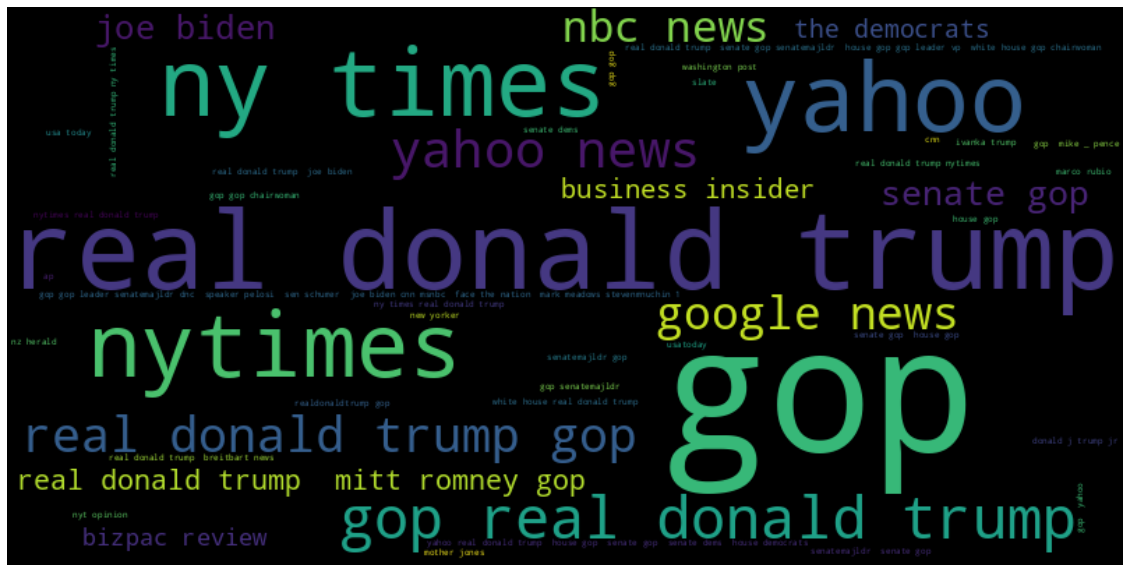

Most commont words in true


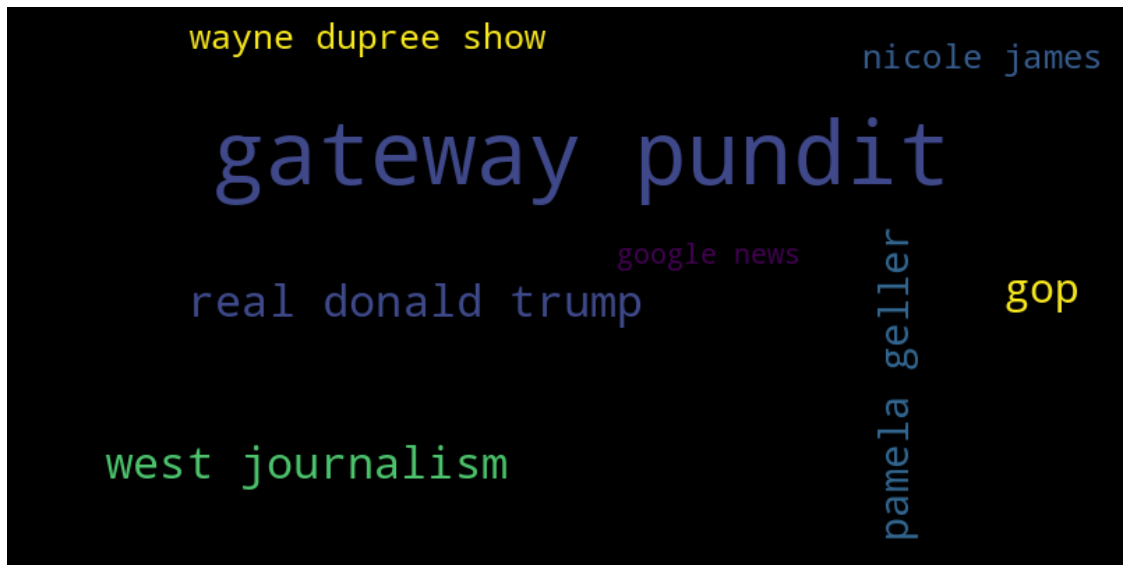

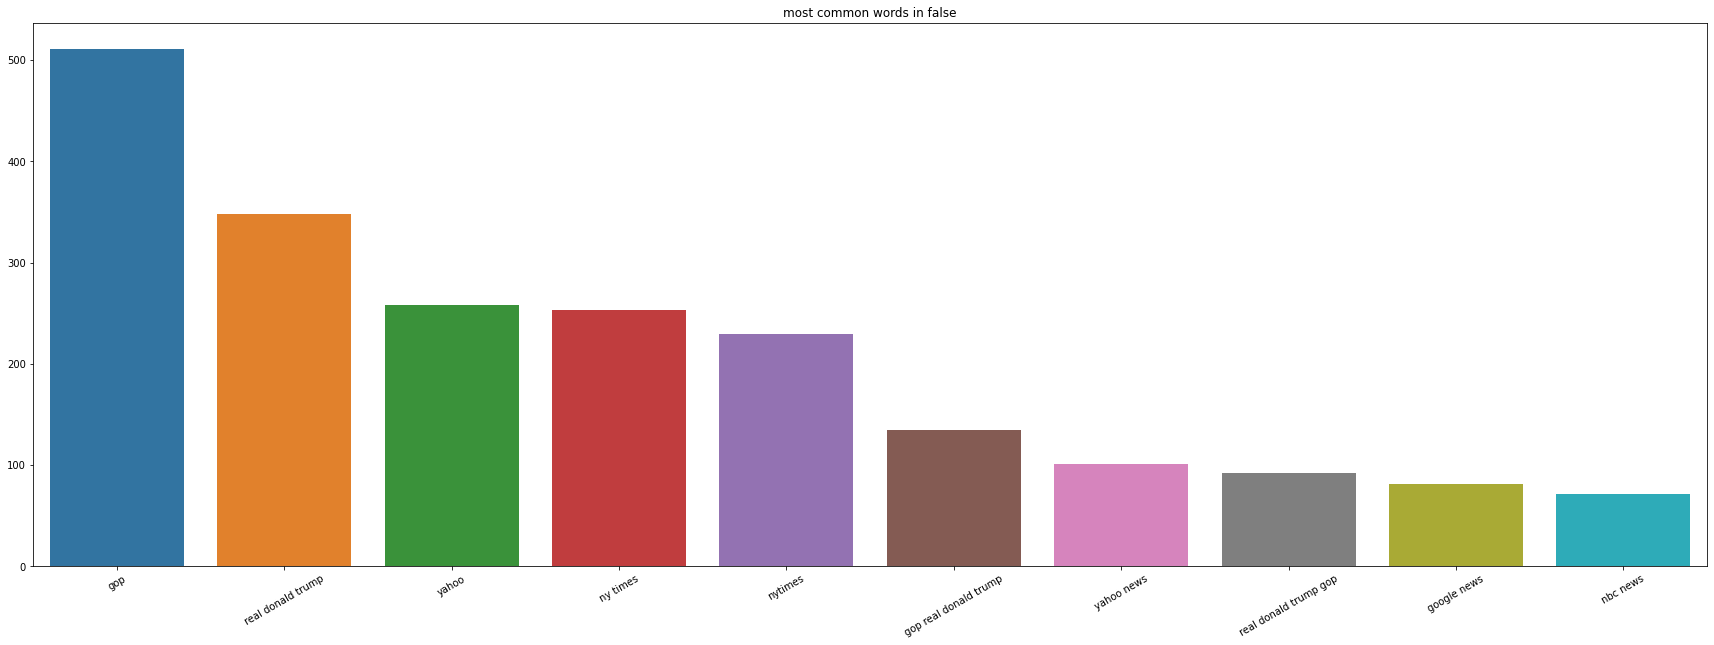

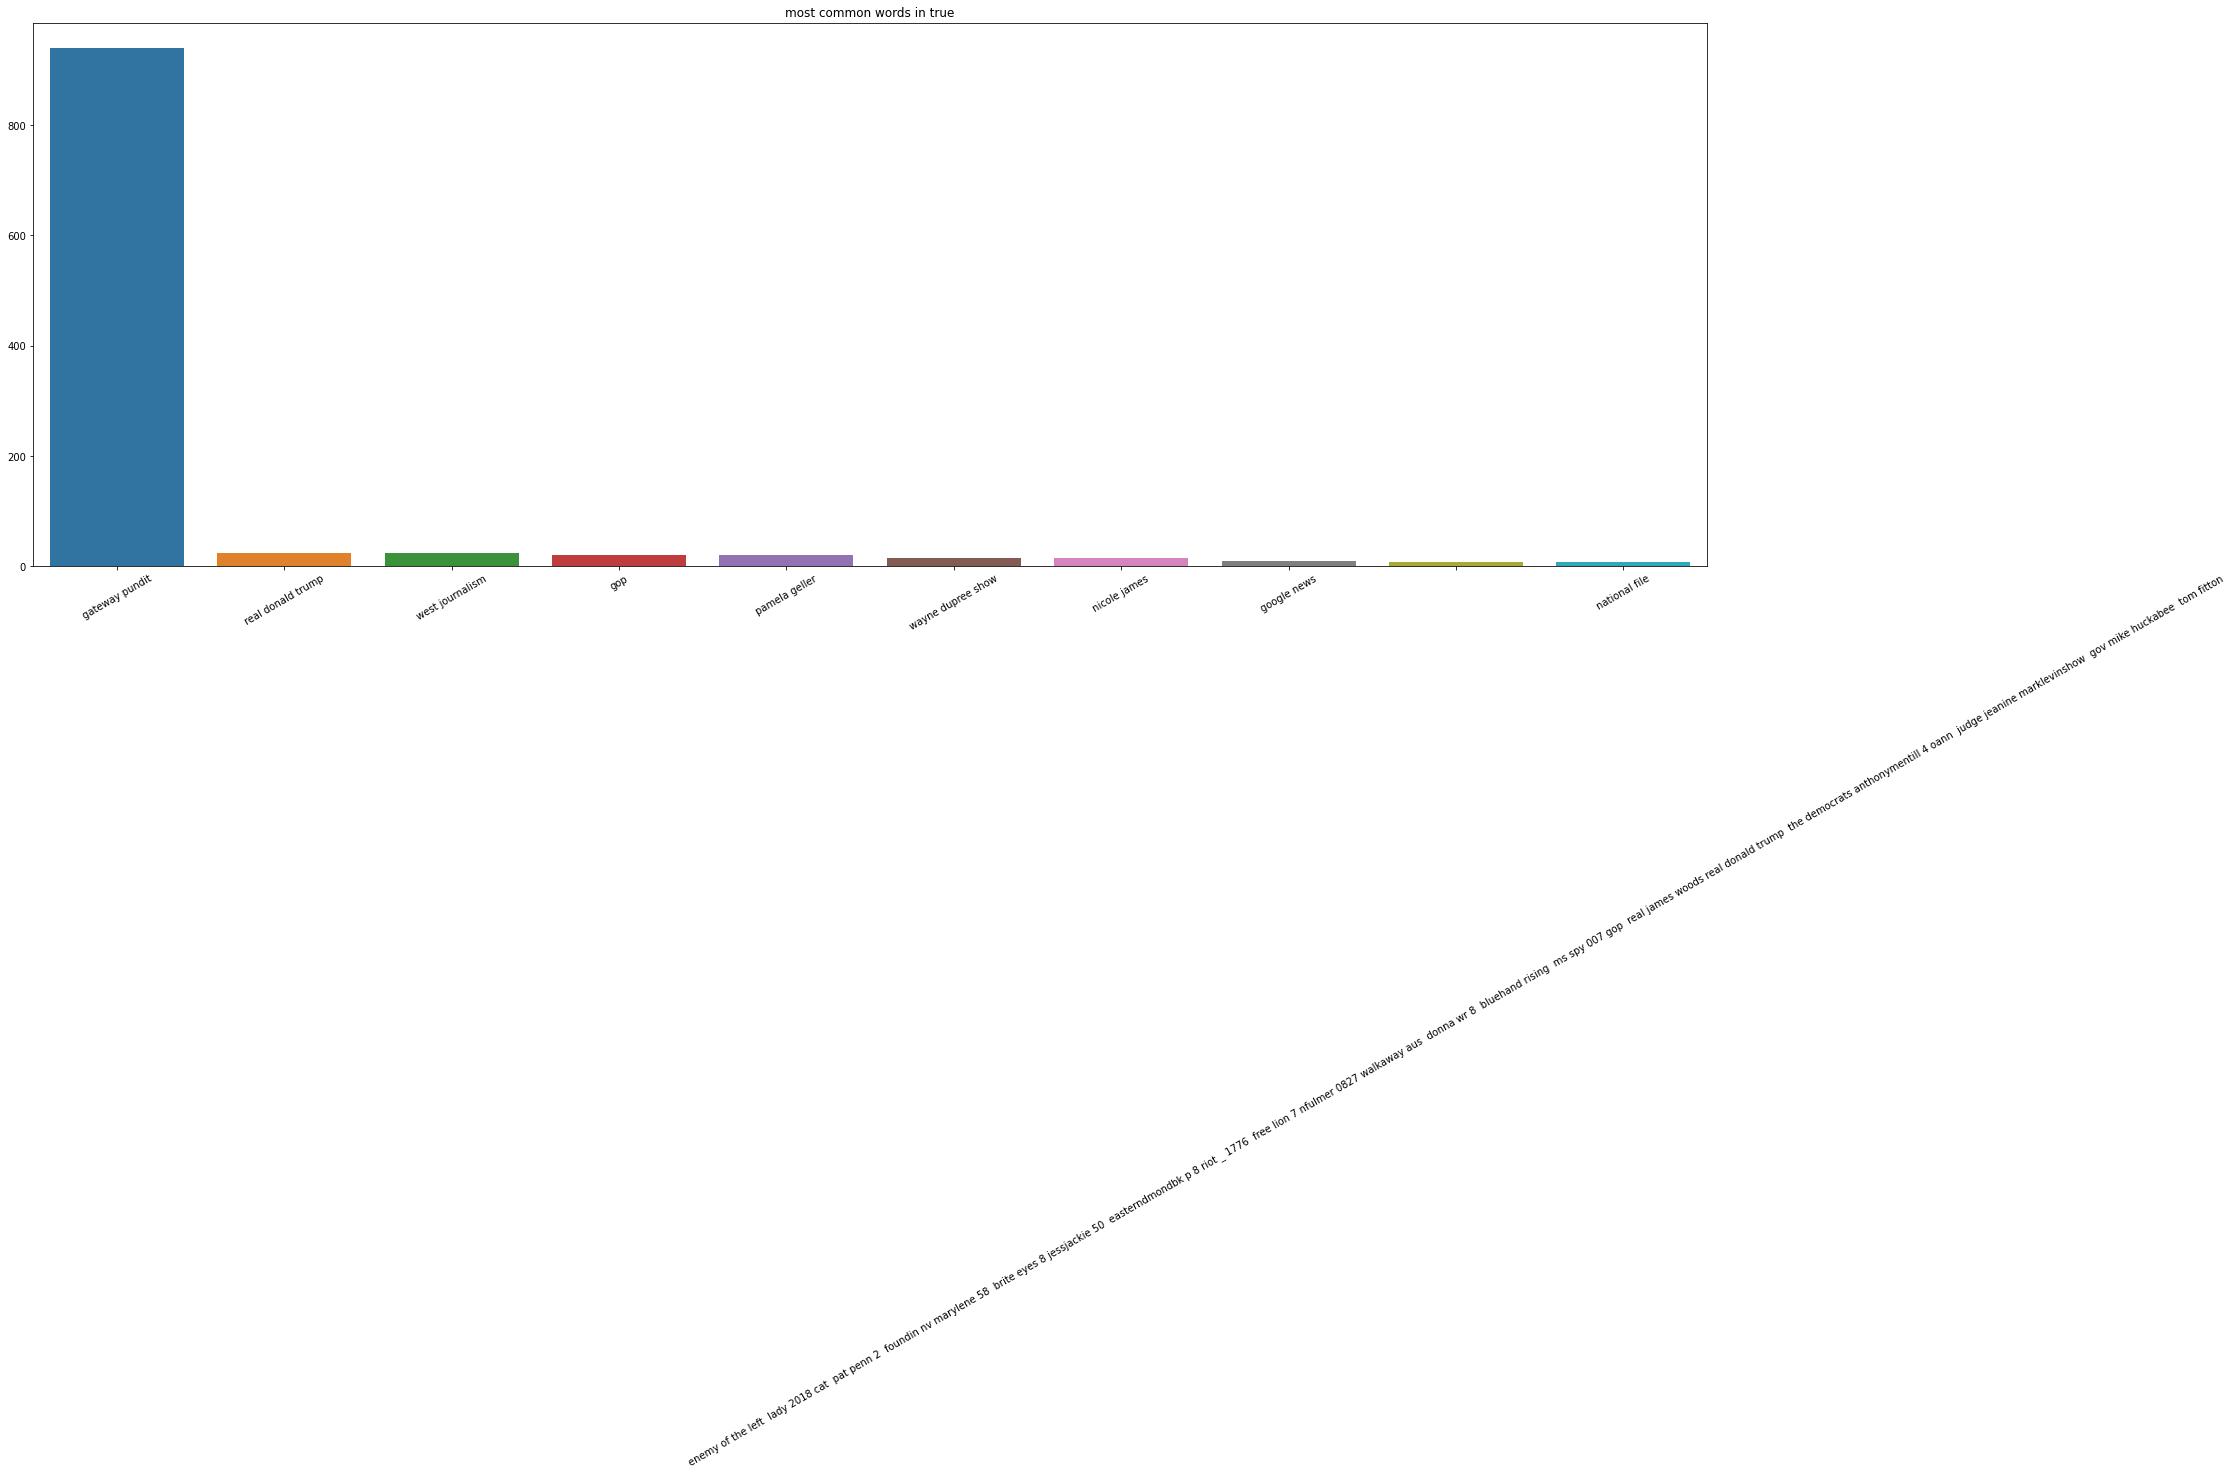

In [31]:
show_freq(data_test_at, 10)

In [32]:
data['common#'] = ''
data['common@'] = ''

for i in range(data['Segmented#'].shape[0]):
    if data.iloc[i]['Segmented#'] in fdist_true_common_hash:
        data.loc[i,'common#'] = 'p_1'
    elif data.iloc[i]['Segmented#'] in fdist_false_common_hash:
        data.loc[i,'common#'] = 'p_2'
    else:
        data.loc[i,'common@'] = 'p_0'
        
for i in range(data['Segmented@'].shape[0]):
    if data.iloc[i]['Segmented@'] in fdist_true_common_at:
        data.loc[i,'common@'] = 'p_1'
    elif data.iloc[i]['Segmented@'] in fdist_false_common_at:
        data.loc[i,'common@'] = 'p_2'
    else:
        data.loc[i,'common@'] = 'p_0'

In [33]:
data['url']=''
for i in range(data['description'].shape[0]):
    data.loc[i,'url'] = p.parse(data.iloc[i]['description']).urls[0].match

In [34]:
print(data['url'][(data['questionable_domain']==True)].isnull().values.any())
print(data['url'][(data['questionable_domain']==False)].isnull().values.any())
print('URL in False')
print(data['url'][(data['questionable_domain']==False)].value_counts())
print('URL in True')
print(data['url'][(data['questionable_domain']==True)].value_counts())

False
False
URL in False
https://t.co/o2MLOpF42M    44
https://t.co/bUXJPMibBa    38
https://t.co/kt9cag3WRz    26
https://t.co/2vY4FdjJWm    21
https://t.co/x9Fx5do8FA    18
                           ..
https://t.co/XQLk6Qq5Ub     1
https://t.co/YhJuasagfP     1
https://t.co/GWC97RxSIq     1
https://t.co/oTeXxCx1Oy     1
https://t.co/TrKylx6h6m     1
Name: url, Length: 14111, dtype: int64
URL in True
https://t.co/apFrJQgxvy    5
https://t.co/NYOaSSwACz    3
https://t.co/Bx9vpKVpQK    3
https://t.co/fC4ysHzI56    3
https://t.co/1VGTHKyHd1    3
                          ..
https://t.co/iUQJbXOdL4    1
https://t.co/oItVBvb6qQ    1
https://t.co/Wv6s5rxjEe    1
https://t.co/FUbxCNEHeo    1
https://t.co/wLjcLT1JZY    1
Name: url, Length: 2955, dtype: int64


URLs irrelevantes para a classificação

In [35]:
data['number_!']=''
for i in range(data['description'].shape[0]):
    data.loc[i,'number_!'] = data.iloc[i]['description'].count('!')

In [36]:
print('% of ! in False')
print(round((data['number_!'][(data['questionable_domain']==False)].value_counts())/(data['number_!'][(data['questionable_domain']==False)].shape[0])*100,2))
print('% of ! in True')
print(round((data['number_!'][(data['questionable_domain']==True)].value_counts())/(data['number_!'][(data['questionable_domain']==True)].shape[0])*100,2))

% of ! in False
0     82.09
1     10.36
2      3.87
3      1.87
4      0.78
5      0.29
6      0.27
10     0.16
7      0.11
9      0.07
8      0.06
11     0.02
12     0.01
13     0.01
16     0.01
21     0.01
29     0.01
50     0.01
Name: number_!, dtype: float64
% of ! in True
0     71.33
1     18.33
2      5.30
3      3.23
4      0.80
5      0.40
6      0.37
7      0.10
9      0.03
10     0.03
12     0.03
13     0.03
Name: number_!, dtype: float64


In [37]:
data['number_words']=''
for i in range(data['text'].shape[0]):
    data.loc[i,'number_words'] = len(data.iloc[i]['text'])

In [38]:
print('Number of words in False')
print(round((data['number_words'][(data['questionable_domain']==False)]).mean(),2))
print('Number of words in True')
print(round((data['number_words'][(data['questionable_domain']==True)]).mean(),2))

Number of words in False
16.79
Number of words in True
16.22


In [39]:
#p.tokenize(data.iloc[2]['description'])

In [40]:
data['user_verified'][(data['questionable_domain']==False)].value_counts()

False    14002
True       948
Name: user_verified, dtype: int64

In [41]:
data['user_verified'][(data['questionable_domain']==True)].value_counts()

False    2975
True       25
Name: user_verified, dtype: int64

In [42]:
data['contains_profanity'][(data['questionable_domain']==False)].value_counts()

False    13542
True      1408
Name: contains_profanity, dtype: int64

In [43]:
data['contains_profanity'][(data['questionable_domain']==True)].value_counts()

False    2870
True      130
Name: contains_profanity, dtype: int64

In [44]:
data['racio'] = round(data['user_followers_count']/(data['user_friends_count']+1),3)
data['racio'].astype(float);

In [45]:
data[['user_friends_count', 'user_followers_count', 'user_favourites_count', 'retweet_count', 'number_!', 'number_words']] = data[['user_friends_count', 'user_followers_count', 'user_favourites_count', 'retweet_count', 'number_!', 'number_words']].astype(int)

## Feature importance

In [46]:
X = data[['user_favourites_count', 'user_verified', 'retweet_count', 'contains_profanity', 'number_!', 'number_words', 'common#', 'common@', 'racio']]
y = data['questionable_domain']

In [47]:
#X_test = data[['user_friends_count', 'user_followers_count', 'user_favourites_count', 'user_verified', 'retweet_count', 'contains_profanity', 'number_!', 'number_words', 'common']]
X= pd.get_dummies(X)

[0.3046565  0.00655499 0.07281517 0.00983288 0.03311289 0.12024269
 0.32076143 0.00060012 0.00109495 0.00098908 0.03230886 0.07984617
 0.01718426]


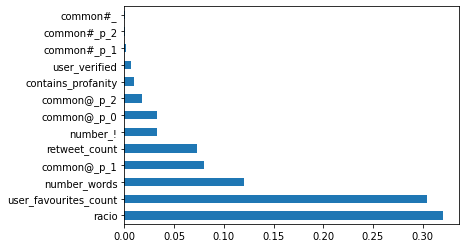

In [48]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [49]:
corrmat = X.corr()
top_corr_features = corrmat.index

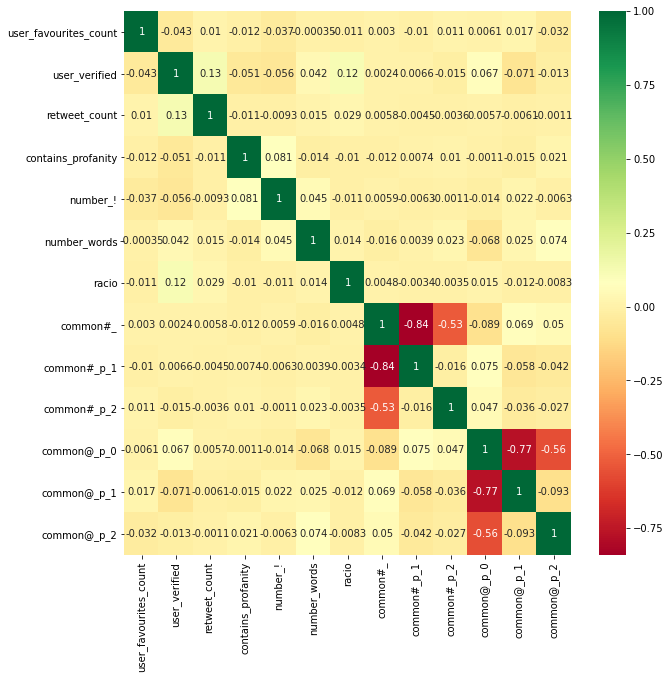

In [50]:
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(X[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model selection

In [51]:
def Test_models(x, y):
    models = [LR(penalty='none'), LDA(), QDA(), RFc(), DTc(), SVMc(kernel='rbf', probability=True), MLPc(activation='relu'), MLPc(activation='tanh'), GNB(), KNN()]
    #modls = ['LR','LDA','QDA','RFc','DTc','SVMc_rbf', 'MLPc_relu','MLPc_tanh']
    
    cmap = colors.ListedColormap(['blue','orange'])

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify = y)

    grid_params_DTc = {'criterion': ['gini', 'entropy'],
        'max_depth': range(2, 10, 2),
        'min_samples_split': range(2, 10, 2),
        'min_samples_leaf': range(2, 10, 2) }    
    grid_params_RFc = {"n_estimators": [100, 200, 400],
             "criterion": ['gini', 'entropy'],
             "min_samples_split": [2, 5, 10, 20],
             "min_samples_leaf": [1, 2 , 5 , 10],
             "min_impurity_decrease": [0.0, 1.0, 2.0]}
    grid_params_SVMc = {'C':[1, 5, 10]}
    grid_params_MLPc = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
            'solver': ['sgd', 'adam'],
            'alpha': [0.0001, 0.05],
            'learning_rate': ['constant','adaptive'],
            'batch_size':[100, 50, 25]}
    grid_params_KNN = {'n_neighbors': range(2,10,2)}


    Acc_train = []
    F1_train = []
    Auc_train =  []
    Rcl_train = []
    Prc_train = []

    Acc_test = []
    F1_test = []
    Auc_test = []
    Rcl_test = []
    Prc_test = []

    T_time = []
    
    for i in range(len(models)):
        mod = models[i]
        if i == 4:
            grid_mod = GridSearchCV(DTc(random_state=0), grid_params_DTc, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        elif i == 3:
            grid_mod = GridSearchCV(RFc(random_state=0), grid_params_RFc, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        elif i == 5:
            grid_mod = GridSearchCV(SVMc(kernel='rbf', probability=True, random_state=0), grid_params_SVMc, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        elif i == 6:
            grid_mod = GridSearchCV(MLPc(activation='relu', random_state=0), grid_params_MLPc, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        elif i == 7:
            grid_mod = GridSearchCV(MLPc(activation='tanh', random_state=0), grid_params_MLPc, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')    
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        elif i == 9:
            grid_mod = GridSearchCV(KNN(), grid_params_KNN, verbose=1, cv=3, n_jobs=-1, scoring = 'f1')    
            grid_mod.fit(x_train, y_train)
            mod = grid_mod.best_estimator_
        else:
            mod = models[i]
        start = time.time()
        mod.fit(x_train, y_train)
        stop = time.time()

        print(mod)
        #print('Accuracy (train):', accuracy_score(y_train, mod.predict(x_train)))
        Acc_train.append(accuracy_score(y_train, mod.predict(x_train)))
        #print('F1 (train):', f1_score(y_train, mod.predict(x_train)))
        F1_train.append(f1_score(y_train, mod.predict(x_train)))
        #print('AUC (train):', roc_auc_score(y_train, mod.predict_proba(x_train)[:, 1]))
        Auc_train.append(roc_auc_score(y_train, mod.predict_proba(x_train)[:, 1]))
        #print('Recall (train):', recall_score(y_train, mod.predict(x_train)))
        Rcl_train.append(recall_score(y_train, mod.predict(x_train)))
        #print('Precision (train):', precision_score(y_train, mod.predict(x_train)))
        Prc_train.append(precision_score(y_train, mod.predict(x_train)))

        #print('Accuracy (test):', accuracy_score(y_test, mod.predict(x_test)))
        Acc_test.append(accuracy_score(y_test, mod.predict(x_test)))
        #print('F1 (test):', f1_score(y_test, mod.predict(x_test)))
        F1_test.append(f1_score(y_test, mod.predict(x_test)))
        #print('AUC (test):', roc_auc_score(y_test, mod.predict_proba(x_test)[:, 1]))
        Auc_test.append(roc_auc_score(y_test, mod.predict_proba(x_test)[:, 1]))
        #print('Recall (test):', recall_score(y_test, mod.predict(x_test)))
        Rcl_test.append(recall_score(y_test, mod.predict(x_test)))
        #print('Precision (test):', precision_score(y_test, mod.predict(x_test)))
        Prc_test.append(precision_score(y_test, mod.predict(x_test)))

        #print(f"Training time: {stop - start}s")
        T_time.append(stop-start)
        print('\n')

    listall = [Acc_train, F1_train, Auc_train, Rcl_train, Prc_train, Acc_test, F1_test, Auc_test, Rcl_test, Prc_test, T_time]

    return listall

In [52]:
def plot_results(result):
    k = 10
    names = ['Acc_train']*k + ['F1_train']*k + ['Auc_train'] * k + ['Rcl_train'] * k + ['Prc_train'] * k + ['Acc_test']*k + ['F1_test']*k + ['Auc_test']*k + ['Rcl_test']*k + ['Prc_test']*k
    group = ['LR', 'LDA', 'QDA', 'RFc', 'DTc', 'SVMc', 'MLPr', 'MLPt', 'GNB', 'KNN']*(len(result)-1)
    group_2 = ['LR', 'LDA', 'QDA', 'RFc', 'DTc', 'SVMc', 'MLPr', 'MLPt', 'GNB', 'KNN']

    def aux(lists):
        list =[]
        for i in range((len(lists)-1)):
            for item in lists[i]:
                list.append(item)
        return list

    data_dict = {
        'x': names,
        'y': aux(result),
        'group': group
    }

    data_time = {
        'y': group_2,
        'x': result[-1]
    }
  
    plt.figure(figsize=(30,10))
    ax_1= sns.barplot(x='x', y='y', hue='group', data = data_dict)
    ax_1.set_title('Results', fontsize = 30)
    ax_1.set_xlabel('Metrics', fontsize = 20)
    ax_1.set_ylabel('Score', fontsize = 20)

    plt.figure(figsize=(10,5))
    ax_2 = sns.barplot(x='x', y='y', data = data_time)
    ax_2.set_title('Training times', fontsize = 25)
    ax_2.set_xlabel('Time (s)', fontsize = 20)
    ax_2.set_ylabel('Models', fontsize = 20)

In [53]:
X_2 = data[['user_favourites_count', 'retweet_count', 'racio']]

LogisticRegression(penalty='none')


LinearDiscriminantAnalysis()


QuadraticDiscriminantAnalysis()


Fitting 3 folds for each of 288 candidates, totalling 864 fits
RandomForestClassifier(n_estimators=200, random_state=0)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
DecisionTreeClassifier(max_depth=8, min_samples_leaf=2, min_samples_split=8,
                       random_state=0)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVC(C=1, probability=True, random_state=0)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
MLPClassifier(alpha=0.05, batch_size=100, random_state=0)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
MLPClassifier(activation='tanh', batch_size=25, hidden_layer_sizes=(50, 50, 50),
              random_state=0)


GaussianNB()


Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier(n_neighbors=2)




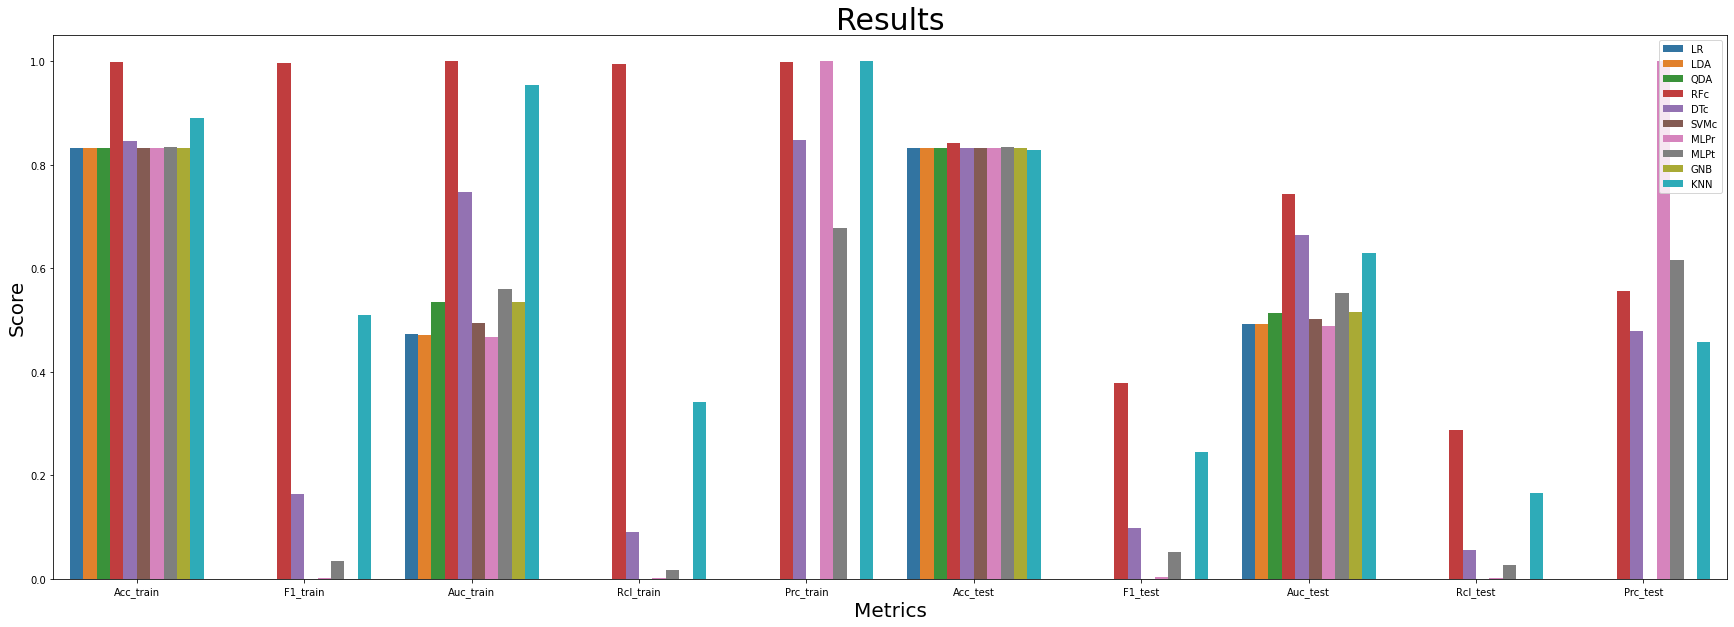

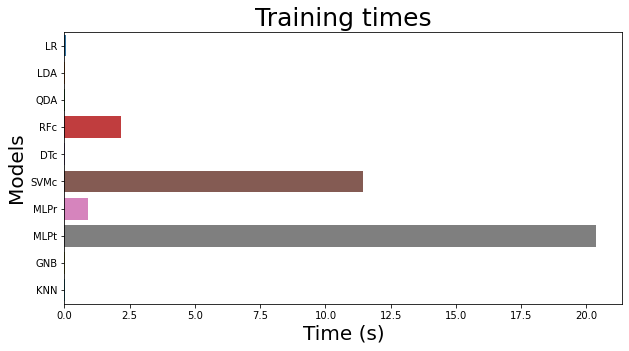

In [54]:
plot_results(Test_models(X_2,y))

LogisticRegression(penalty='none')


LinearDiscriminantAnalysis()


QuadraticDiscriminantAnalysis()


Fitting 3 folds for each of 288 candidates, totalling 864 fits
RandomForestClassifier(criterion='entropy', n_estimators=400, random_state=0)


Fitting 3 folds for each of 128 candidates, totalling 384 fits
DecisionTreeClassifier(max_depth=8, min_samples_leaf=6, random_state=0)


Fitting 3 folds for each of 3 candidates, totalling 9 fits
SVC(C=1, probability=True, random_state=0)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
MLPClassifier(alpha=0.05, batch_size=50, random_state=0)


Fitting 3 folds for each of 72 candidates, totalling 216 fits
MLPClassifier(activation='tanh', batch_size=100,
              hidden_layer_sizes=(50, 100, 50), random_state=0)


GaussianNB()


Fitting 3 folds for each of 4 candidates, totalling 12 fits
KNeighborsClassifier(n_neighbors=2)




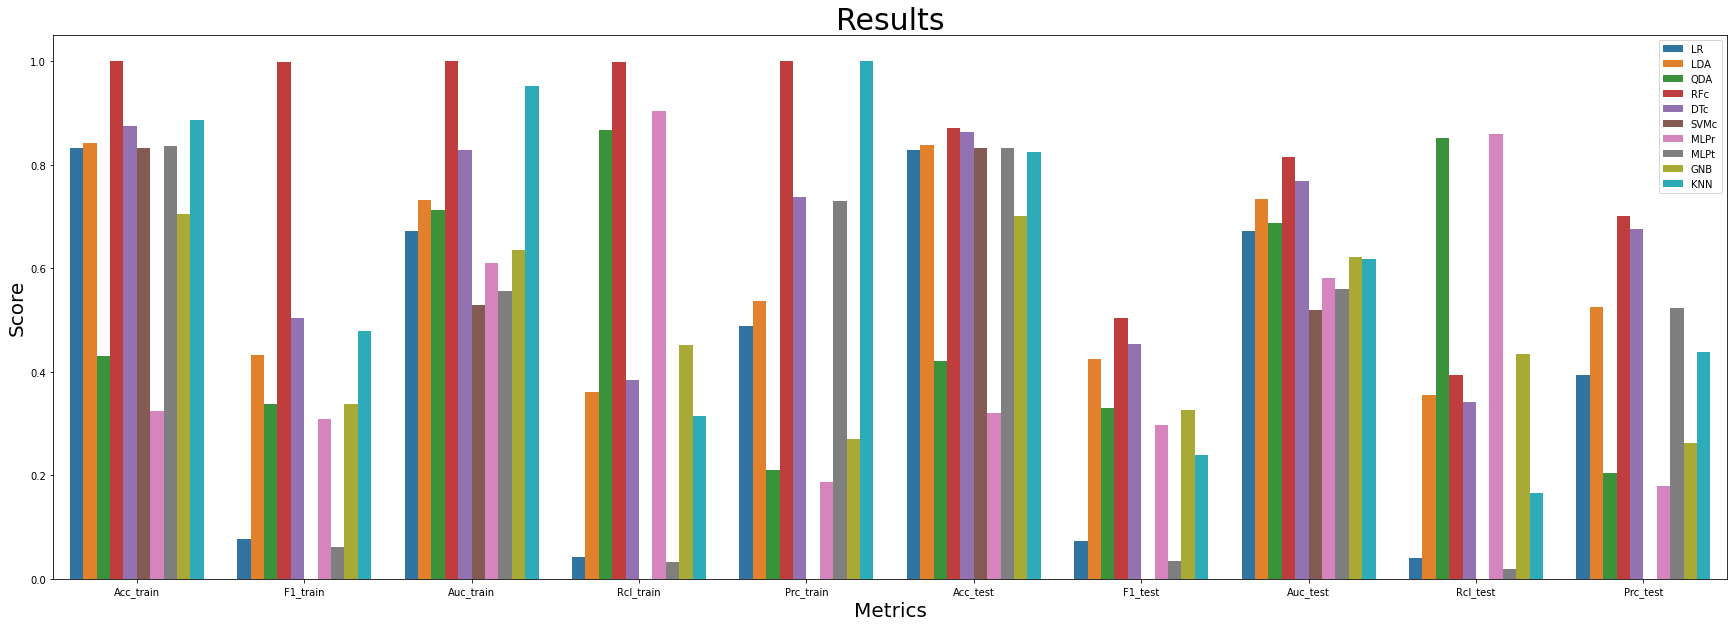

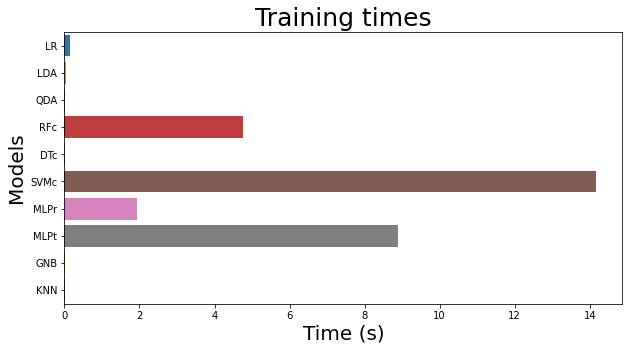

In [55]:
plot_results(Test_models(X,y))